  Nate Reedel
  Final Project #6
  Description: Sentiment Analysis using an RNN on data derived from the Corona outbreak. The analysis is to find the general sentiment of locations, based on tweets, as to determine its level of mental trauma.



In [1]:
# Imports #
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
tfds.disable_progress_bar()

In [2]:
# Upload Corona.xlsx#
from google.colab import files
uploaded = files.upload()

Saving Corona.xlsx to Corona.xlsx


In [3]:
# Create Data Frame from Corona.xlsx #
file_path = 'Corona.xlsx'
df = pd.read_excel(io.BytesIO(uploaded[file_path]))

In [4]:
# Info #
print("\n\nInfo")
df.info()



Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
# Head of fields of interest #
selected_col = ['Location','OriginalTweet','Sentiment']
df[selected_col].head(5)

,Location,OriginalTweet,Sentiment
0,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,My food stock is not the only one which is emp...,Positive
4,NaN,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
# Possible categorical values for each sentiment #
unique_values = df['Sentiment'].unique()
print(unique_values)

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


## Input Pipeline for Usable Data
Location strings & Sentiment 'categorical' strings are selected for the sentiment analysis. Sentiment is encoded since their none numeric categories. The data sets are then converted into a single data table.

In [7]:
# String fields used for analysis
X_np = df['Location'].values.astype(str)
y_np = df['Sentiment'].values.astype(str)

# Map sentiment categories to numeric values
sentiment_mapping = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

# Encode sentiment labels to numeric values
y_encoded = [sentiment_mapping[sentiment] for sentiment in y_np]

# Create a data table using the related data
data = pd.DataFrame({'Location': X_np, 'Sentiment': y_encoded})

##Train for Text Vectorization
Train formated data and shuffle the results. Adapt trained data Location field to the vectorization.

In [8]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Set constants
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Create TensorFlow datasets by shuffling data
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['Location'].values.astype(str), train_data['Sentiment'].values))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a text vectorization layer
vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_mode='int')
vectorizer.adapt(train_data['Location'].values.astype(str))

##RNN Model
Create RNN model, compile and fit it.Test for loss and accuracy.

In [14]:
# Define the model
model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64),
    tf.keras.layers.LSTM(64),  # LSTM for RNN
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.8),  # Dropout layer for regularization
    tf.keras.layers.Dense(5, activation='softmax')  # Five categories for sentiment
])

# Show masking support
print("Masking Support")
print([layer.supports_masking for layer in model.layers],"\n")

# Compile with configurations
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model using trained and test data
model.fit(train_dataset, epochs=10, validation_data=(test_data['Location'].values.astype(str), test_data['Sentiment']))

# Evaluate the models test values
test_loss, test_accuracy = model.evaluate(test_data['Location'].values.astype(str), test_data['Sentiment'])
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Masking Support
[False, False, True, True, True] 

Epoch 1/10
515/515 [==============================] - 11s 16ms/step - loss: 1.5776 - accuracy: 0.2750 - val_loss: 1.5728 - val_accuracy: 0.2778
Epoch 2/10
515/515 [==============================] - 7s 14ms/step - loss: 1.5660 - accuracy: 0.2786 - val_loss: 1.5781 - val_accuracy: 0.2753
Epoch 3/10
515/515 [==============================] - 10s 19ms/step - loss: 1.5148 - accuracy: 0.3256 - val_loss: 1.6176 - val_accuracy: 0.2552
Epoch 4/10
515/515 [==============================] - 9s 17ms/step - loss: 1.4372 - accuracy: 0.3721 - val_loss: 1.6414 - val_accuracy: 0.2634
Epoch 5/10
515/515 [==============================] - 8s 16ms/step - loss: 1.3734 - accuracy: 0.3911 - val_loss: 1.7073 - val_accuracy: 0.2620
Epoch 6/10
515/515 [==============================] - 7s 14ms/step - loss: 1.3283 - accuracy: 0.4007 - val_loss: 1.7686 - val_accuracy: 0.2632
Epoch 7/10
515/515 [==============================] - 8s 16ms/step - loss: 1.3056 - accur

In [11]:
# Predict Sentiment methods #

def predict_sentiment(location):
    # Make a prediction using the model
    predicted_sentiment = model.predict([location])

    # Get the index of the maximum prediction
    predicted_index = np.argmax(predicted_sentiment[0])

    # Map the predicted index to the sentiment category using the sentiment_mapping dictionary
    sentiment_mapping_reverse = {v: k for k, v in sentiment_mapping.items()}
    predicted_sentiment_category = sentiment_mapping_reverse[predicted_index]

    # Unpack wanted data
    return predicted_index, predicted_sentiment_category, predicted_sentiment

def display_prediction(local):
    value, predicted_sentiment_category, predicted_sentiment = predict_sentiment(local)
    print('Sentiment for', local)
    print(' - prediction =', predicted_sentiment_category)
    print(' - mental health [0-4] =', value)
    print()

In [ ]:
# Predict sentiments of varies known Cities & Countries #

# Countries #
print("COUNTRY")
display_prediction('Brazil')
display_prediction('Canada')
display_prediction('India')
display_prediction('Mexico')
display_prediction('Russia')
display_prediction('United Kingdom')
display_prediction('United States')


# Cities #
print("\nCITY")
display_prediction('Dehli')
display_prediction('London')
display_prediction('Los Angeles')
display_prediction('New York')

COUNTRY
1/1 [==============================] - 0s 495ms/step
Sentiment for Brazil
 - prediction = Extremely Positive
 - mental health [0-4] = 4

1/1 [==============================] - 0s 34ms/step
Sentiment for Canada
 - prediction = Positive
 - mental health [0-4] = 3

1/1 [==============================] - 0s 34ms/step
Sentiment for India
 - prediction = Positive
 - mental health [0-4] = 3

1/1 [==============================] - 0s 36ms/step
Sentiment for Mexico
 - prediction = Negative
 - mental health [0-4] = 1

1/1 [==============================] - 0s 34ms/step
Sentiment for Russia
 - prediction = Negative
 - mental health [0-4] = 1

1/1 [==============================] - 0s 39ms/step
Sentiment for United Kingdom
 - prediction = Positive
 - mental health [0-4] = 3

1/1 [==============================] - 0s 36ms/step
Sentiment for United States
 - prediction = Positive
 - mental health [0-4] = 3


CITY
1/1 [==============================] - 0s 36ms/step
Sentiment for Dehli
 - pred

Epoch 1/10
515/515 [==============================] - 8s 16ms/step - loss: 1.2625 - accuracy: 0.4115 - val_loss: 2.0734 - val_accuracy: 0.2654
Epoch 2/10
515/515 [==============================] - 10s 19ms/step - loss: 1.2579 - accuracy: 0.4138 - val_loss: 2.0716 - val_accuracy: 0.2683
Epoch 3/10
515/515 [==============================] - 7s 14ms/step - loss: 1.2545 - accuracy: 0.4134 - val_loss: 2.1283 - val_accuracy: 0.2688
Epoch 4/10
515/515 [==============================] - 7s 14ms/step - loss: 1.2518 - accuracy: 0.4157 - val_loss: 2.1823 - val_accuracy: 0.2705
Epoch 5/10
515/515 [==============================] - 7s 14ms/step - loss: 1.2497 - accuracy: 0.4151 - val_loss: 2.1796 - val_accuracy: 0.2707
Epoch 6/10
515/515 [==============================] - 8s 16ms/step - loss: 1.2467 - accuracy: 0.4155 - val_loss: 2.1432 - val_accuracy: 0.2676
Epoch 7/10
515/515 [==============================] - 7s 14ms/step - loss: 1.2426 - accuracy: 0.4180 - val_loss: 2.2067 - val_accuracy: 0.269

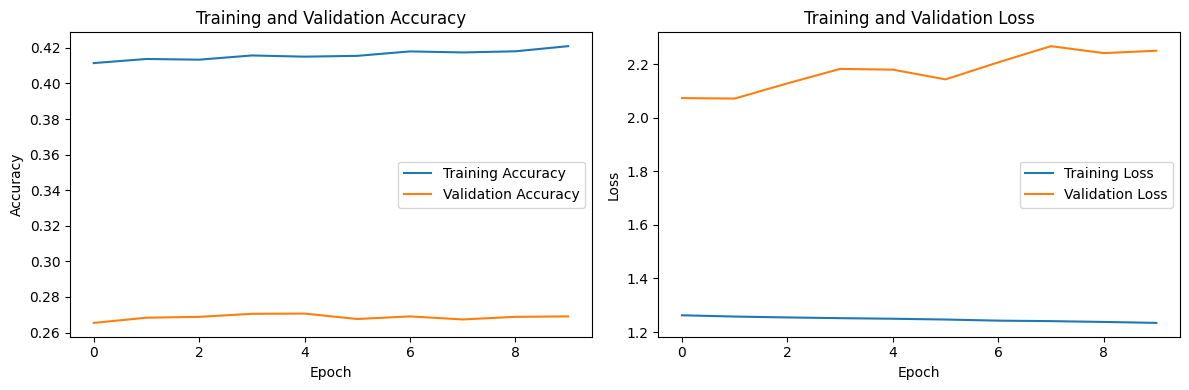

In [17]:

# Train the model using the dataset and save the history
history = model.fit(train_dataset, epochs=10, validation_data=(test_data['Location'].values.astype(str), test_data['Sentiment']))

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
#### END ####